# 1. SETUP & IMPORT LIBRARIES

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import Counter
from wordcloud import WordCloud
import numpy as np
import os

## Konfigurasi Visualisasi

In [26]:
sns.set_palette("viridis")
sns.set_style("whitegrid")
plt.rcParams.update({'figure.dpi': 120})

## Stopwords Simple

In [27]:
STOPWORDS_ID = set([
    'di', 'ke', 'dari', 'dan', 'ini', 'itu', 'yang', 'untuk', 'dengan',
    'saja', 'tidak', 'tapi', 'ada', 'bisa', 'karena', 'yg', 'gak', 'ga',
    'aja', 'juga', 'akan', 'pada', 'sih', 'kok', 'deh', 'ya',
    'adalah', 'sebagai', 'merupakan', 'saya', 'kamu', 'mereka',
])

# 2. HELPER FUNCTIONS

In [28]:
def find_hashtags(tweet):
    """Mengekstrak hashtag (#)"""
    return re.findall(r"#(\w+)", str(tweet))

def find_mentions(tweet):
    """Mengekstrak mention (@)"""
    return re.findall(r"@(\w+)", str(tweet))

def find_uppercase_words(tweet):
    """Mengekstrak kata yang ditulis full kapital (min. 2 huruf)"""
    return re.findall(r'\b[A-Z]{2,}\b', str(tweet))

def find_urls(tweet):
    """Mengekstrak URL"""
    return re.findall(r'http\S+|www\.\S+', str(tweet))

def clean_for_wordcloud(text):
    """Pembersihan minimal untuk visualisasi (hapus mention, hashtag, URL)"""
    text = str(text)
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    text = re.sub(r'#\w+', '', text)
    text = re.sub(r'http\S+|www\.\S+', '', text)
    return text.lower()

def get_top_n_items(df_subset, col, n=5, prefix=''):
    """Helper untuk mengambil Top N item dari kolom bertipe list"""
    all_items = [it.lower() for sub in df_subset[col] for it in sub]
    if not all_items: return pd.DataFrame({'Item': [f"{prefix}N/A"], 'Count': [0]})
    c = Counter(all_items)
    items, counts = zip(*c.most_common(n))
    return pd.DataFrame({'Item': [f"{prefix}{i}" for i in items], 'Count': counts})

# 3. DATA LOADING & FEATURE ENGINEERING

In [29]:
file_path = r"E:\My Drive\Indonesia AI\Fundamental NLP\Project 1\Data_raw\tweet.csv"
try:
    df = pd.read_csv(file_path)
except FileNotFoundError:
    print(f"ERROR: File tidak ditemukan di {file_path}.")
    exit()

print("--- Data Loading & Feature Engineering Dimulai ---")
# Pembersihan Awal & Konsistensi
df['sentimen'] = df['sentimen'].astype(str).str.lower()
df['tweet'] = df['tweet'].astype(str)

# Ekstraksi Fitur
df['panjang_tweet'] = df['tweet'].str.len()
df['hashtags'] = df['tweet'].apply(find_hashtags)
df['mentions'] = df['tweet'].apply(find_mentions)
df['uppercase_words'] = df['tweet'].apply(find_uppercase_words)
df['urls'] = df['tweet'].apply(find_urls)
df['jumlah_seru'] = df['tweet'].str.count(r'!')
df['jumlah_tanya'] = df['tweet'].str.count(r'\?')
df['tweet_bersih'] = df['tweet'].apply(clean_for_wordcloud)

# Feature Biner (Untuk Analisis Persentase)
df['has_hashtag'] = df['hashtags'].apply(lambda x: 1 if len(x) > 0 else 0)
df['has_mention'] = df['mentions'].apply(lambda x: 1 if len(x) > 0 else 0)
df['has_url'] = df['urls'].apply(lambda x: 1 if len(x) > 0 else 0)
print("--- Feature Engineering Selesai. Data Siap Analisis. ---\n")

--- Data Loading & Feature Engineering Dimulai ---
--- Feature Engineering Selesai. Data Siap Analisis. ---



# 4. EXPLORATORY DATA ANALYSIS (EDA) & VISUALISASI

## 4.1. Analisis Distribusi Sentimen (Data Balancing)

4.1. DISTRIBUSI SENTIMEN (DATA BALANCING)
Persentase Distribusi Sentimen:
 sentimen
positif    33.72%
netral     33.44%
negatif    32.84%
Name: count, dtype: object


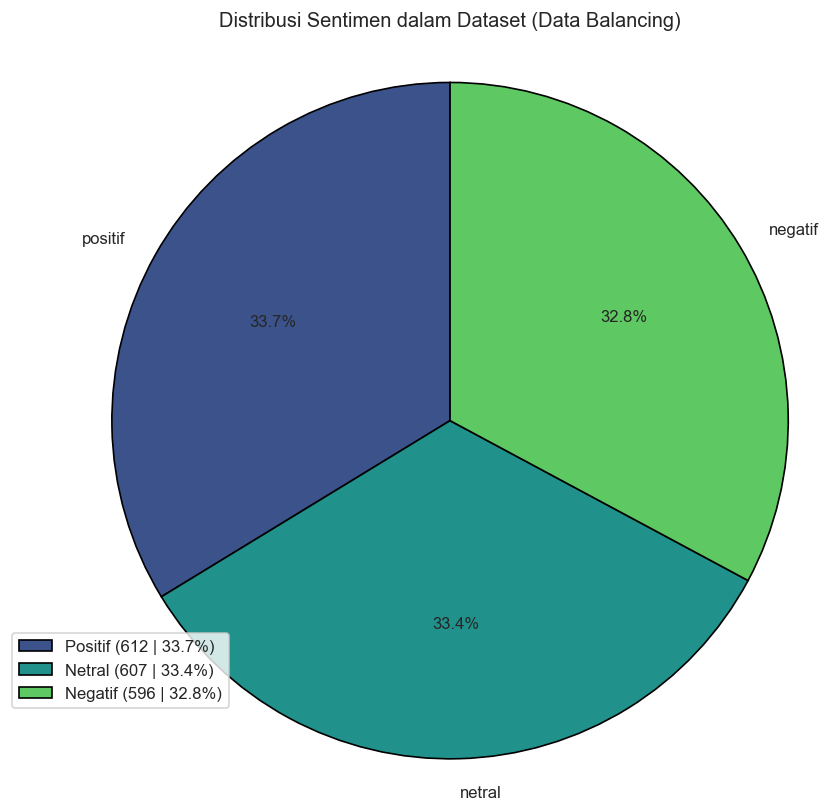

In [46]:
print("="*80); print("4.1. DISTRIBUSI SENTIMEN (DATA BALANCING)"); print("="*80)
sentiment_counts = df['sentimen'].value_counts()
total_tweets = len(df)
sentiment_percentage = (sentiment_counts / total_tweets) * 100
print("Persentase Distribusi Sentimen:\n", sentiment_percentage.round(2).astype(str) + '%')

plt.figure(figsize=(8, 8)) # Menggunakan rasio 1:1 agar Pie Chart berbentuk lingkaran sempurna

# Membuat label untuk Pie Chart: menggabungkan sentimen, jumlah, dan persentase
pie_labels = [f'{s.capitalize()} ({c} | {p:.1f}%)'
              for s, c, p in zip(
                  sentiment_counts.index, 
                  sentiment_counts.values, 
                  sentiment_percentage.values
              )]

# Membuat Pie Chart
plt.pie(
    sentiment_counts.values,
    labels=sentiment_counts.index, # Hanya menggunakan nama sentimen sebagai label di chart
    autopct='%1.1f%%', # Menampilkan persentase dengan 1 angka di belakang koma
    startangle=90,     # Memulai potongan pertama dari atas (pukul 12)
    colors=sns.color_palette("viridis", len(sentiment_counts)), # Menggunakan palet yang sama
    wedgeprops={"edgecolor": "black", 'linewidth': 1} # Menambahkan garis tepi agar lebih rapi
)

# Menambahkan legenda terpisah yang lebih informatif
plt.legend(
    loc='lower left', 
    labels=pie_labels, 
    fontsize=10, 
    bbox_to_anchor=(-0.1, 0.1) # Memposisikan legenda di luar plot
)

plt.title('Distribusi Sentimen dalam Dataset (Data Balancing)', y=1.02) 
plt.axis('equal') # Memastikan Pie Chart berbentuk lingkaran
plt.show()

## 4.2. Analisis Linguistik: Panjang Tweet

4.2. PANJANG TWEET PER SENTIMEN
Statistik Panjang Tweet per Sentimen:
           count    mean    std   min    25%    50%    75%    max
sentimen                                                        
negatif   596.0  189.28  73.90  30.0  129.0  193.0  255.0  408.0
netral    607.0  187.23  77.62  39.0  126.0  189.0  243.5  668.0
positif   612.0  207.30  73.49  27.0  147.0  221.5  268.0  390.0


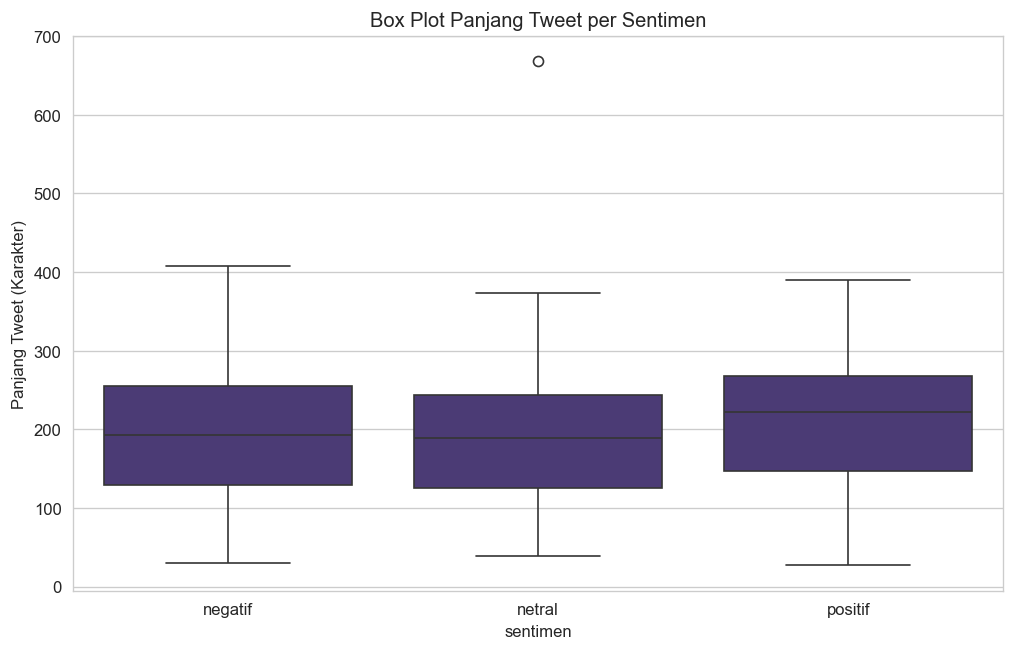

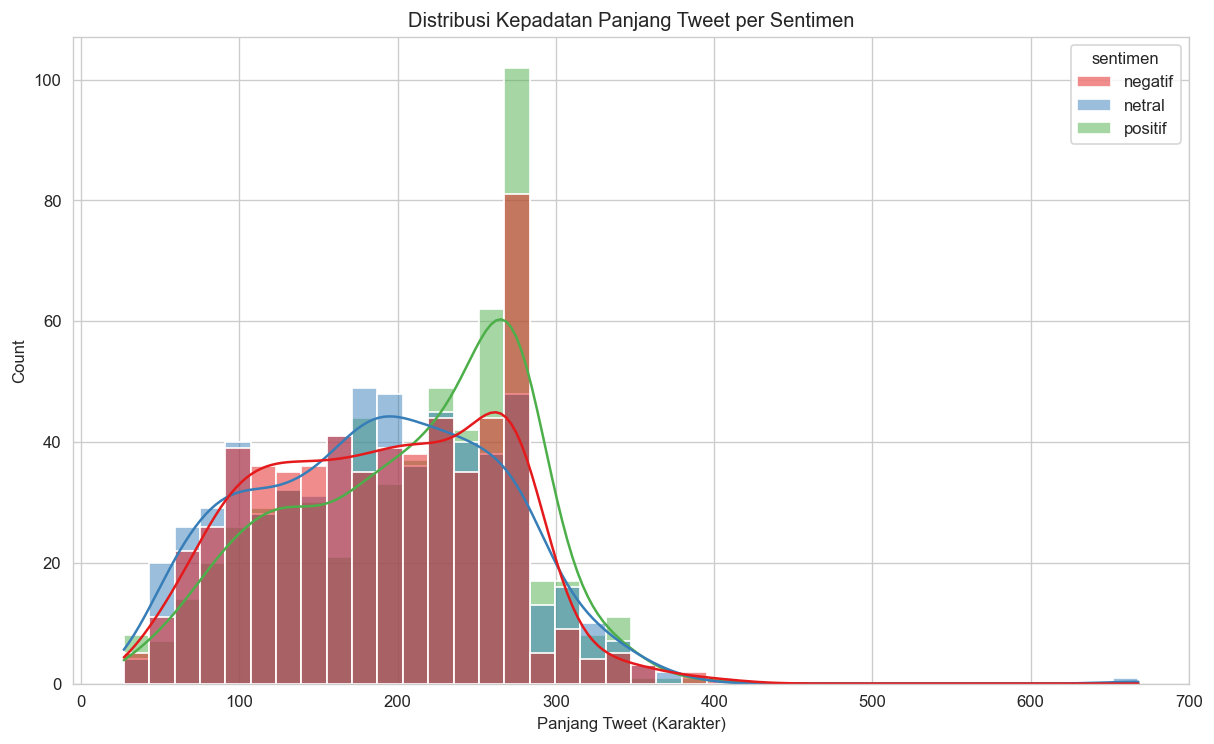

In [31]:
print("="*80); print("4.2. PANJANG TWEET PER SENTIMEN"); print("="*80)
print("Statistik Panjang Tweet per Sentimen:\n", df.groupby('sentimen')['panjang_tweet'].describe().round(2))

plt.figure(figsize=(10, 6)); sns.boxplot(x='sentimen', y='panjang_tweet', data=df)
plt.title('Box Plot Panjang Tweet per Sentimen'); plt.ylabel('Panjang Tweet (Karakter)'); plt.show()
plt.figure(figsize=(12, 7)); sns.histplot(data=df, x='panjang_tweet', hue='sentimen', kde=True, bins=40, palette='Set1')
plt.title('Distribusi Kepadatan Panjang Tweet per Sentimen'); plt.xlabel('Panjang Tweet (Karakter)'); plt.show()

## 4.3. Analisis Penggunaan Entitas (%)

4.3. PERSENTASE PENGGUNAAN ENTITAS & URL
Persentase Tweet yang Mengandung Entitas per Sentimen:
           % Has Hashtag  % Has Mention  % Has URL
sentimen                                         
negatif           19.97          19.80      12.42
netral            35.26          25.37      46.79
positif           35.62          28.59      17.81


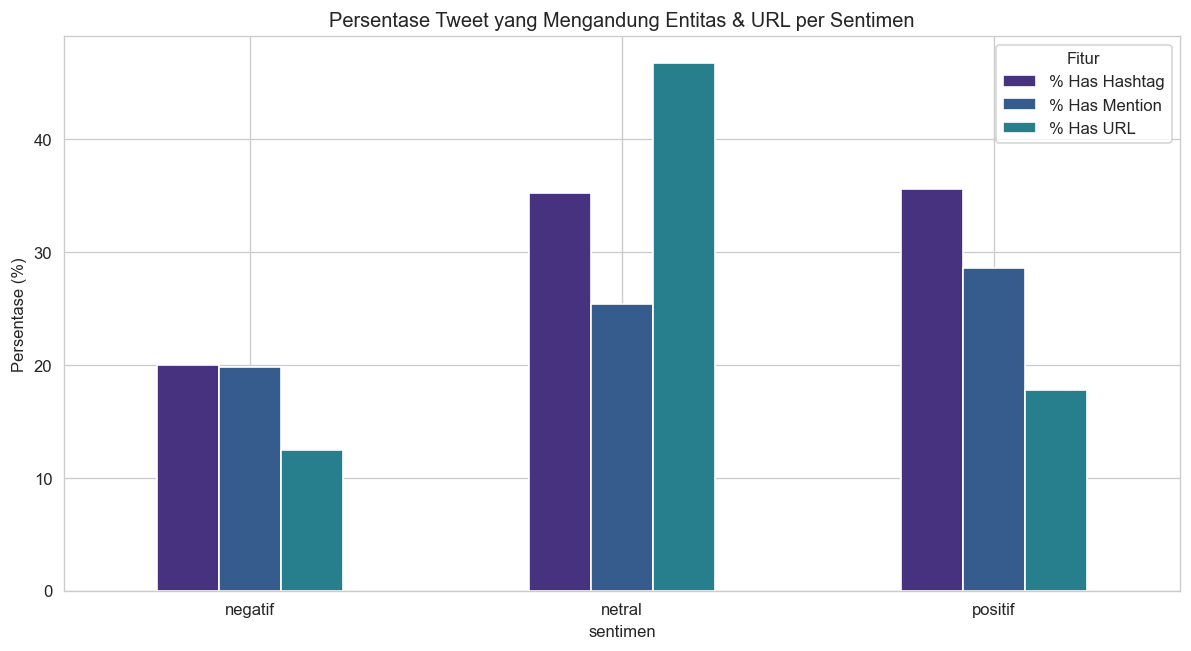

In [32]:
print("="*80); print("4.3. PERSENTASE PENGGUNAAN ENTITAS & URL"); print("="*80)
entity_percentage = df.groupby('sentimen')[['has_hashtag', 'has_mention', 'has_url']].mean() * 100
entity_percentage.columns = ['% Has Hashtag', '% Has Mention', '% Has URL']
print("Persentase Tweet yang Mengandung Entitas per Sentimen:\n", entity_percentage.round(2))

entity_percentage.plot(kind='bar', figsize=(12, 6), rot=0)
plt.title('Persentase Tweet yang Mengandung Entitas & URL per Sentimen')
plt.ylabel('Persentase (%)'); plt.legend(title='Fitur'); plt.show()

## 4.4. Analisis Tanda Baca

4.4. RATA-RATA TANDA BACA
          jumlah_seru  jumlah_tanya
sentimen                           
negatif          0.25          0.61
netral           0.05          0.20
positif          0.16          0.16


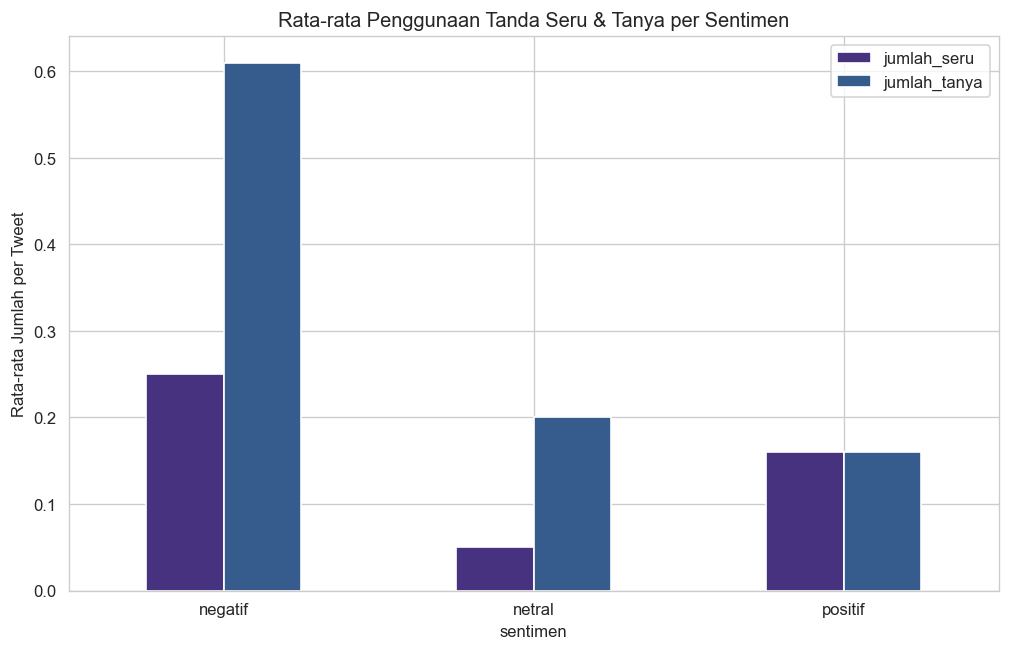

In [33]:
print("="*80); print("4.4. RATA-RATA TANDA BACA"); print("="*80)
punctuation_analysis = df.groupby('sentimen')[['jumlah_seru', 'jumlah_tanya']].mean().round(2)
print(punctuation_analysis)
punctuation_analysis.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title('Rata-rata Penggunaan Tanda Seru & Tanya per Sentimen'); plt.ylabel('Rata-rata Jumlah per Tweet'); plt.show()

## 4.5. Visualisasi Top N Fitur per Sentimen (Grid)

4.5. TOP 5 FITUR LINGUISTIK PER SENTIMEN


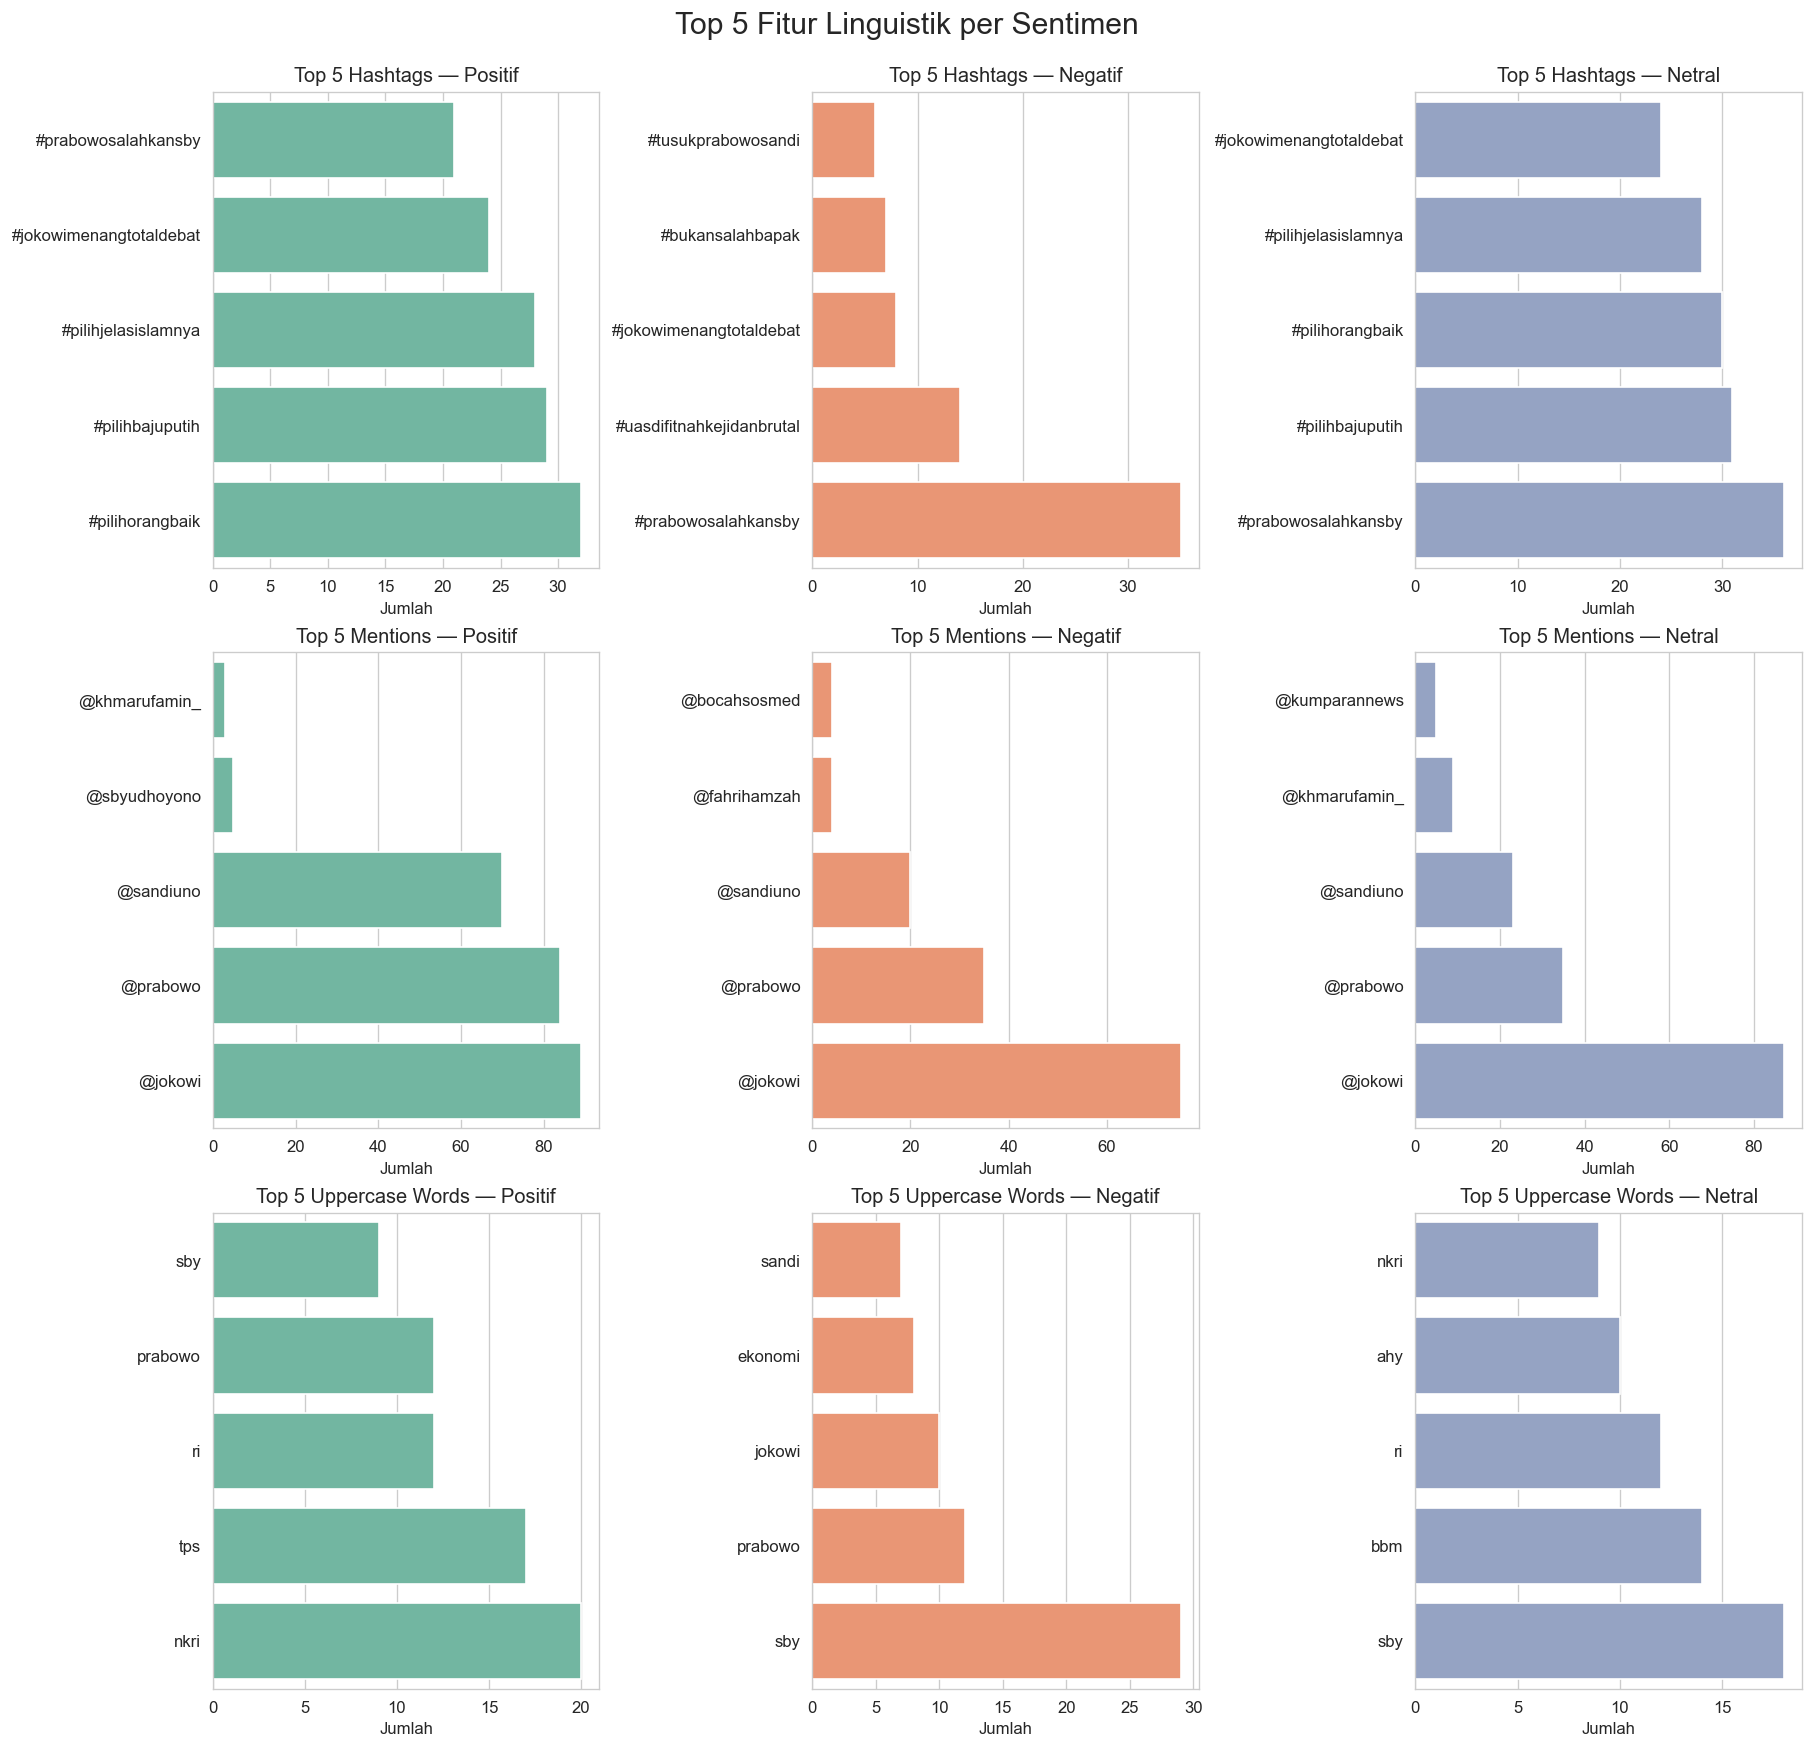

In [34]:
print("="*80); print("4.5. TOP 5 FITUR LINGUISTIK PER SENTIMEN"); print("="*80)
sentiments = ['positif', 'negatif', 'netral']
features = [('hashtags', '#'), ('mentions', '@'), ('uppercase_words', '')]

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 14), constrained_layout=True)

for i, col_tuple in enumerate(features):
    col, prefix = col_tuple
    for j, sent in enumerate(sentiments):
        ax = axes[i, j]
        df_sub = df[df['sentimen'] == sent]
        plot_df = get_top_n_items(df_sub, col, n=5, prefix=prefix)
        plot_df = plot_df.iloc[::-1]

        sns.barplot(x='Count', y='Item', data=plot_df, ax=ax, orient='h',
                    color=sns.color_palette("Set2")[j])
        col_title = col.replace('_', ' ').title()
        ax.set_title(f"Top 5 {col_title} — {sent.capitalize()}")
        ax.set_xlabel('Jumlah'); ax.set_ylabel('')

fig.suptitle("Top 5 Fitur Linguistik per Sentimen", fontsize=18, y=1.03)
plt.show()

## 4.6. Word Cloud Comparison

4.6. WORD CLOUD COMPARISON


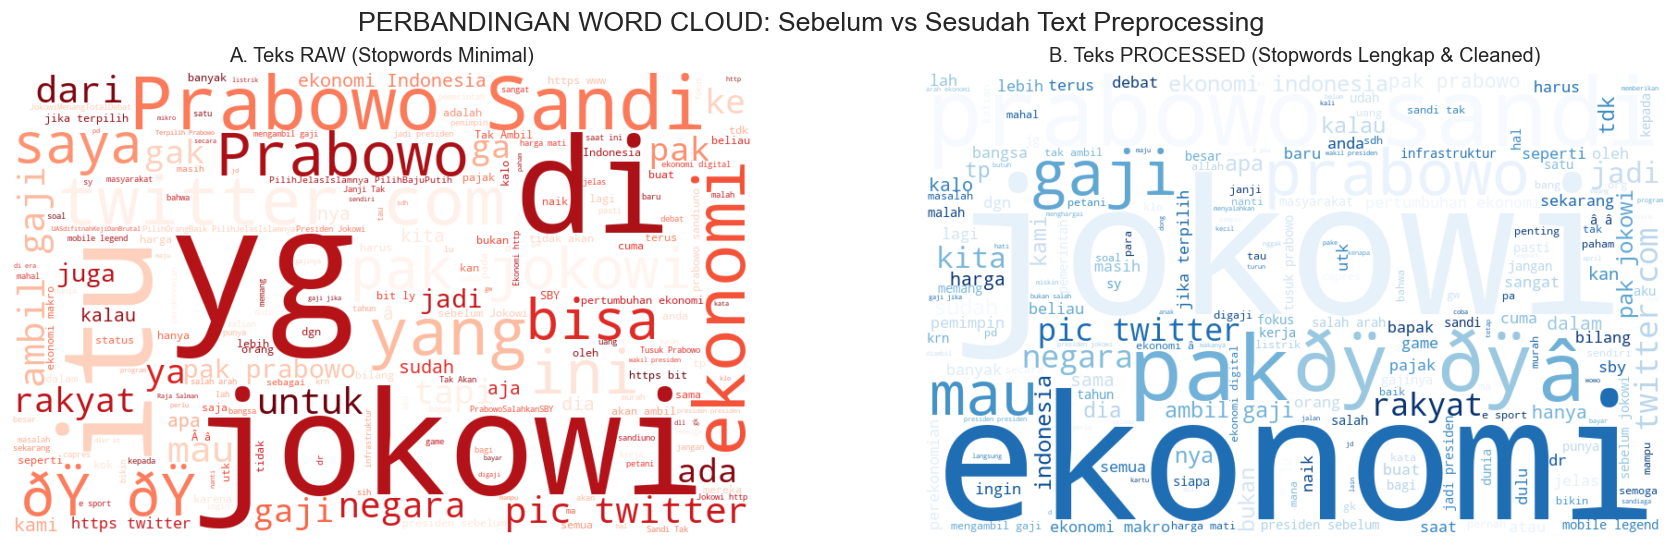

In [41]:
print("="*80); print("4.6. WORD CLOUD COMPARISON"); print("="*80)
all_raw_text = ' '.join(df['tweet'])
all_clean_text = ' '.join(df['tweet_bersih'])
minimal_stopwords = set(['dan', 'atau', 'dengan'])

wordcloud_raw = WordCloud(width=800, height=500, background_color='white', stopwords=minimal_stopwords, colormap='Reds').generate(all_raw_text)
wordcloud_clean = WordCloud(width=800, height=500, background_color='white', stopwords=STOPWORDS_ID, colormap='Blues').generate(all_clean_text)

fig, axes = plt.subplots(1, 2, figsize=(18, 5))
axes[0].imshow(wordcloud_raw, interpolation='bilinear'); axes[0].axis('off'); axes[0].set_title('A. Teks RAW (Stopwords Minimal)')
axes[1].imshow(wordcloud_clean, interpolation='bilinear'); axes[1].axis('off'); axes[1].set_title('B. Teks PROCESSED (Stopwords Lengkap & Cleaned)')
plt.suptitle('PERBANDINGAN WORD CLOUD: Sebelum vs Sesudah Text Preprocessing', fontsize=16)
plt.show()